<a href="https://colab.research.google.com/github/pmcey/PyTorch_DCGAN_ULA/blob/main/PyTorch_DCGAN_ULA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Let's create a DCGAN network featuring my cat 'Ula' 🐱 </h1>

<img src="https://res.cloudinary.com/jerrick/image/upload/v1514493943/teqcyxcn1hboqpuwifcq.gif" width="500" alt="cat.gif">

<h2> Introduction </h2>

<h4> In this notebook, we'll go through all the stages of creating a Generative Adversarial Network (GAN) to generate new cat images. The idea came to my mind as a test to see if I could trick my girlfriend into believing the authenticity of the generated image using a simple DCGAN network. Enjoy! </h4>

<h3> What is a GAN/DCGAN? </h3>
<h4>
A GAN consists of two independent models. The generator model generates images from random noise, while the discriminator model tries to predict whether the image is real or fake. They constantly complement each other, striving to create truly realistic images. DCGAN (Deep Convolutional Generative Adversarial Network) enhances the traditional GAN architecture by adding convolutional layers. </h4>

<h2> Converting images </h2>

<h4> This part of the program is responsible for loading and converting images. Since the photos were taken with an iPhone, they are in the .heic format. However, for the network, we need a standard format like JPEG. I'm keeping this part because I constantly take pictures of Ula, and the more photos, the better :) </h4>

In [ ]:
#installing and loading necessary libraries
from PIL import Image
!pip install heic2png
from heic2png import HEIC2PNG

#and mounting gdrive where my photos are
import os
from google.colab import drive
drive.mount("/content/drive")

#ignore warning
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#heic to png function
def heic_conv(heic_folder, png_folder):
  i = 0
  files = os.listdir(heic_folder)

  if not os.path.exists(png_folder):
            !mkdir "$png_folder"

  for file in files:
      if (file.endswith(".heic") or file.endswith(".HEIC")):
          image_path = os.path.join(heic_folder, file)
          output_path = os.path.join(png_folder, file[:-5]+'.png')


          if not os.path.exists(output_path):
            png_img = HEIC2PNG(image_path, quality=90)
            print(output_path)
            png_img.save(output_path)
            i += 1

  print("Converted files: ", i)


In [ ]:
#png to img function
def png_conv(png_folder, jpg_folder):
  i = 0
  files = os.listdir(png_folder)

  if not os.path.exists(jpg_folder):
    !mkdir "$jpg_folder"

  for file in files:
    if file.endswith(".png"):
      image_path = os.path.join(png_folder, file)
      output_path = os.path.join(jpg_folder, file[:-4]+'.jpg')

      if not os.path.exists(output_path):
            jpg_img = Image.open(image_path)
            jpg_img =jpg_img.resize((256,256))
            jpg_img = jpg_img.convert("RGB")
            jpg_img.save(output_path, format='JPEG')
            print(output_path)
            i += 1
  print("Converted files: ", i)

In [ ]:
#folders path
heic_folder = "/content/drive/MyDrive/Globtrak/Ula/ula_heic"
png_folder = "/content/drive/MyDrive/Globtrak/Ula/ula_png/"
jpg_folder = "/content/drive/MyDrive/Globtrak/Ula/ula_jpg/dataloader/"

In [ ]:
#convert all to .jpg
heic_conv(heic_folder, png_folder)
png_conv(png_folder, jpg_folder)

Converted files:  0
Converted files:  0


#Network setting and loading data

In [ ]:
#other necessary libraries

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

<h3> Some inputs for the run:

In [ ]:
#directory of images
dataroot = "/content/drive/MyDrive/Globtrak/Ula/ula_jpg/"

#number of workers for dataloader
workers = 2

#batch size for training
batch_size = 4

#image size
image_size = 128

#number of channels. Color images have 3
nc = 3

#number of training epochs
num_epochs = 500

#learning rate for generator as well as discriminator
lr = 0.0002

#number of GPUs available.
ngpu = 1

#some default params
nz = 100; ngf = 64; ndf = 64; beta1 = 0.5

<h4> Now, we can create dataloader and some basic transforms </h4>

In [ ]:
#creating the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
#creating the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

#line of code that allows us to use GPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

<h2> Visualization

<h4> Let's take a look at how Ula the cat appears after the transformations <h/4>

In [ ]:
real_batch = next(iter(dataloader))
print(real_batch[0][0])
print("\nshape: ", real_batch[0][0].shape, ": 3 channels, 128x128 image")

tensor([[[ 0.4980,  0.3020,  0.1765,  ...,  0.3647,  0.4353,  0.4431],
         [ 0.7647,  0.6627,  0.4902,  ...,  0.4588,  0.4667,  0.4431],
         [ 0.4745,  0.7176,  0.7882,  ...,  0.4745,  0.4824,  0.4745],
         ...,
         [-0.9608, -0.9294, -0.6549,  ..., -0.2314, -0.2471, -0.2235],
         [-0.9451, -0.9137, -0.4745,  ..., -0.2392, -0.2392, -0.2235],
         [-0.9373, -0.8980, -0.3412,  ..., -0.2471, -0.2549, -0.2392]],

        [[ 0.5059,  0.3020,  0.1765,  ...,  0.3569,  0.4275,  0.4353],
         [ 0.7725,  0.6627,  0.4902,  ...,  0.4510,  0.4588,  0.4353],
         [ 0.4667,  0.7020,  0.7725,  ...,  0.4667,  0.4745,  0.4667],
         ...,
         [-0.9451, -0.9529, -0.7176,  ..., -0.5216, -0.5373, -0.5137],
         [-0.9373, -0.9373, -0.5608,  ..., -0.5294, -0.5294, -0.5137],
         [-0.9294, -0.9216, -0.4275,  ..., -0.5373, -0.5451, -0.5294]],

        [[ 0.4431,  0.2392,  0.1059,  ...,  0.3255,  0.3961,  0.4039],
         [ 0.7255,  0.6157,  0.4275,  ...,  0

<h4> The same image, but with a more "cat-like" appearance: >.< </h4>

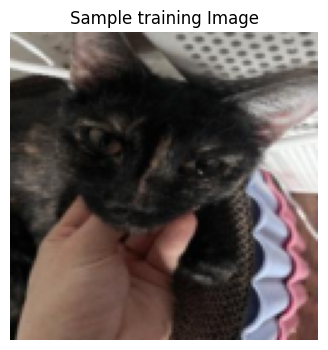

In [ ]:
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Sample training Image")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

<h2> Weights </h2>

<h4> Generator, discriminator and weights_init function code are taken from <a href="https://github.com/pytorch/examples/issues/70">github</a> <h/4>

<h4>
According to the DCGAN network description, both the generator and discriminator should have weights initialized from a Normal distribution with mean=0 and standard deviation=0.02. This function will be executed at the program's start. </h4>

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

<h2> Generator </h2>


In [ ]:
#generator code:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
          # input is Z, going into a convolution
          nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf * 16),
          nn.ReLU(True),
          # state size. (ngf*16) x 4 x 4
          nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 8),
          nn.ReLU(True),
          # state size. (ngf*8) x 8 x 8
          nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # state size. (ngf*4) x 16 x 16
          nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # state size. (ngf*2) x 32 x 32
          nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          # state size. (ngf) x 64 x 64
          nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x 128 x 128
      )

    def forward(self, input):
        return self.main(input)

In [ ]:
#moving the generator to the GPU
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

#apply weights function
print("Generator model: ")
netG.apply(weights_init)

Generator model: 


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
#create the Discriminator
netD = Discriminator(ngpu).to(device)

#handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

#apply weights function
netD.apply(weights_init)

#print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [ ]:
#initialize the 'BCELoss' function
criterion = nn.BCELoss()

# Create random noise
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

#convention for real and fake labels during training
real_label = 1.
fake_label = 0.

#stup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/10, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

<h4> Training loop taken from the technical documentation: </h4>

In [ ]:
#training Loop

#lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(300):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


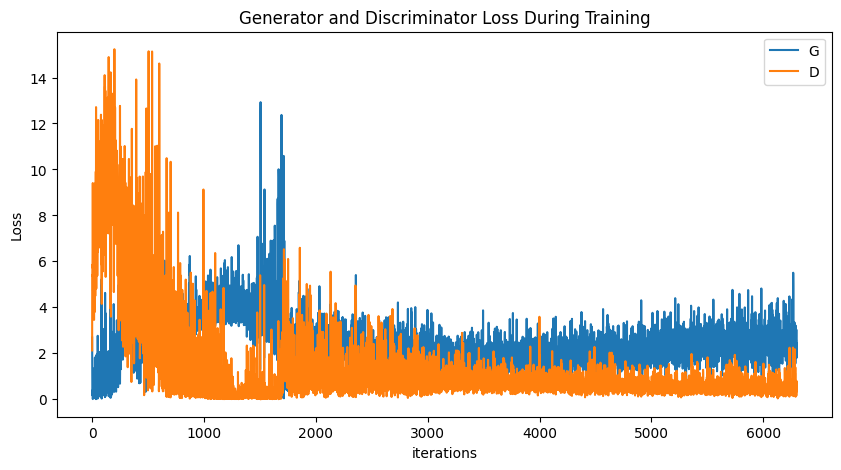

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

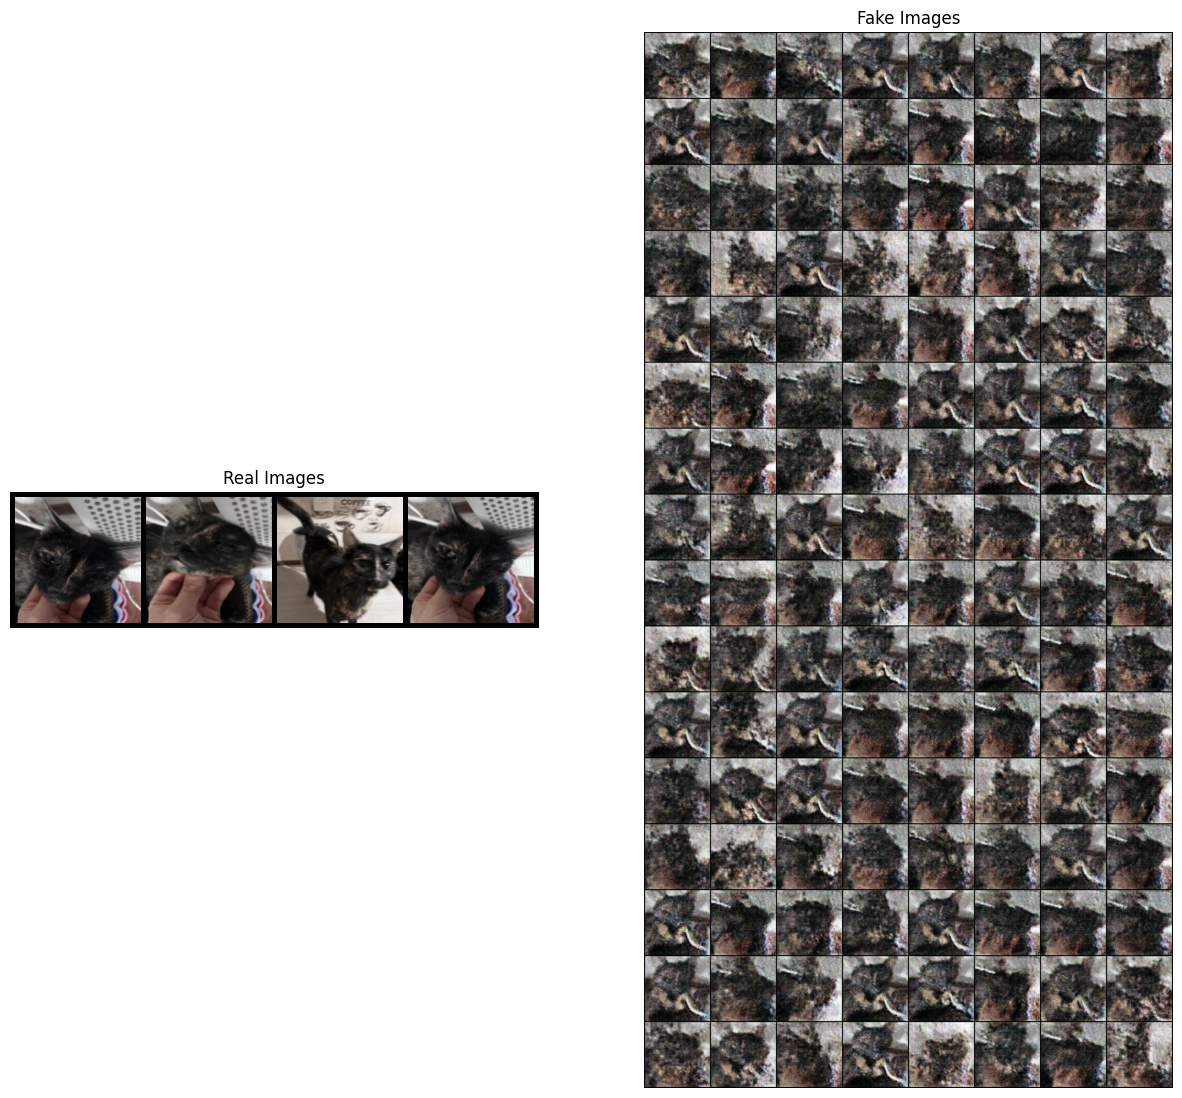

In [ ]:
#a batch of real images from the dataloader
real_batch = next(iter(dataloader))

#plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

#plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

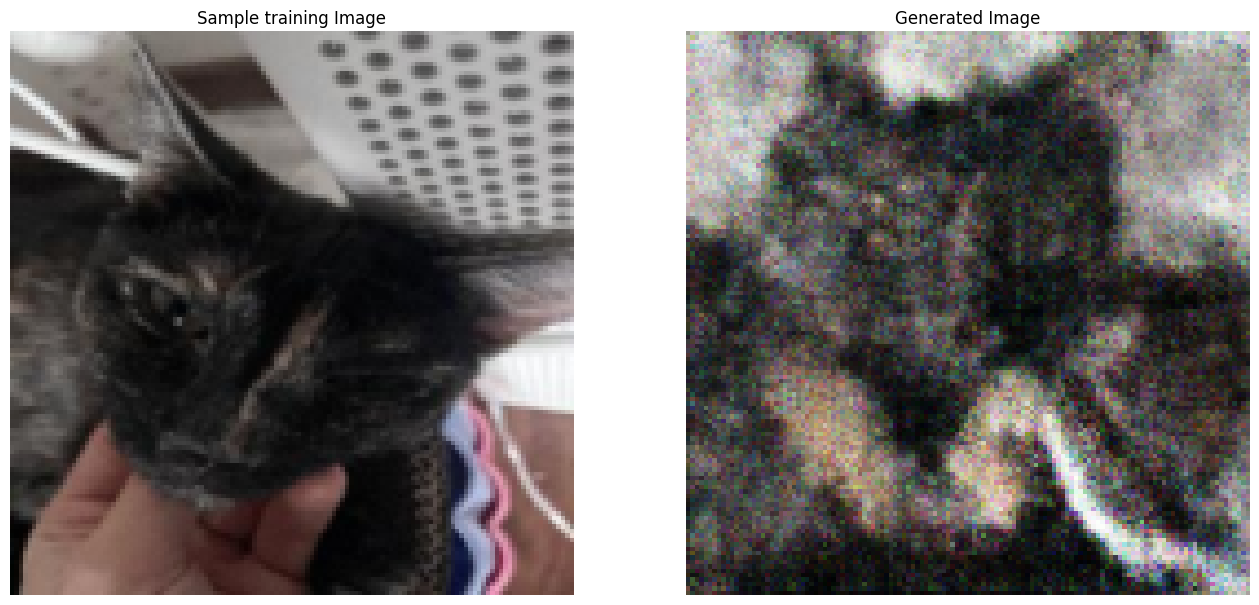

In [ ]:
netG.eval()

with torch.no_grad():
    noise = torch.randn(1, nz, 1, 1, device=device)

fake_image = netG(noise).detach().cpu()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
#real
ax[0].axis("off")
ax[0].set_title("Sample training Image")
ax[0].imshow(np.transpose(vutils.make_grid(real_batch[0][0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))
#fake
ax[1].axis("off")
ax[1].set_title("Generated Image")
ax[1].imshow(np.transpose(vutils.make_grid(fake_image, padding=2, normalize=True), (1, 2, 0)))
plt.show()


<br><br>
<hr>
<br><br>
<h2>As you can see, the cat "Ula" looks about like herself. 🐱 It's worth noting that she was generated from completely random pixel noise, and only Discriminator was trained on real photos.<br> I think, if I told my girlfriend that the picture was taken with a very old camera, she would believe it's real 😀</h2>


<h4>Credits:</h4>
<h5>
I am the author of the notebook and the idea contained within it, however the DCGAN code comes from GitHub and the technical documentation: <br>
<a href='https://github.com/pytorch/examples/issues/70'>GitHub</a> <br>
<a href='https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html'>PyTorch</a>

<br>
<hr>
Descriptions of the libraries I used: <br>
<a href='https://pypi.org/project/HEIC2PNG/'>HEIC2PNG</a> <br>
<a href='https://pillow.readthedocs.io/en/stable/'>Pillow</a>


<br>
<hr>
</h5>